In [9]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [10]:
# ===== SESSION SELECTION =====
SESSION = "pup2"         # animal id
STIM = "brush_contra"  # stim type
# =============================

# Load table (prefer local override if present)
table_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',')  # your CSV is tab-delimited

# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")

row = row.iloc[0]

# Extract paths and metadata
phy_dir = Path(row['phy_dir']) 
ap_dir  = Path(row['ap_dir'])
lfp_dir  = Path(row['lfp_dir']) / 'continuous.dat'
age = str(row['age']).strip() 
notes = str(row['notes']).strip() 

# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])

# Insertion depth 
tip_dv_mm = float(row['tip_dv_mm'])

# Constants
BANK_SPAN_MM = 3.84  # Neuropixels 1.0 recording bank span

# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if ap_dir is None or not ap_dir.exists():
    print(f"⚠️ Warning: ap_dir not found or empty for {SESSION}/{STIM}. Check paths.")

print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"ap_dir:  {ap_dir}")
print(f"lfp_dir: {lfp_dir}")

Loaded: pup2 / brush_contra (age: p12)
Notes: Oop something
phy_dir: C:\Users\Ben\Desktop\Contra Brush\PUP2
ap_dir:  E:\Neurpixels_Sally\pup2_SZMB_brush_contra_final_2024-12-19_16-47-20\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-AP
lfp_dir: E:\Neurpixels_Sally\pup2_SZMB_brush_contra_final_2024-12-19_16-47-20\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-LFP\continuous.dat


In [11]:
# Core arrays
spike_times = np.load(phy_dir/'spike_times.npy')                 # (n_spikes,) in samples
spike_clusters = np.load(phy_dir/'spike_clusters.npy')           # (n_spikes,)
spike_positions = np.load(phy_dir/'spike_positions.npy')         # (n_spikes, 2) columns ~ [x_um, y_um]
channel_positions = np.load(phy_dir/'channel_positions.npy')     # (n_channels, 2)
channel_map = np.load(phy_dir/'channel_map.npy')                 # (n_channels,)
templates = np.load(phy_dir/'templates.npy')                     # (n_templates, t, n_channels)
spike_templates = np.load(phy_dir/'spike_templates.npy')         # (n_spikes,)
params_txt = (phy_dir/'params.py').read_text()


Bank span: 3.82 mm
Top of bank: -1.32 mm DV
Tip (deepest site): 2.50 mm DV
Channels in brain: 251/383


C:\Users\Ben\AppData\Local\Temp\ipykernel_24348\2620641396.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Saved: results\figures\pup2_brush_contra_raster_lfp_30s.png


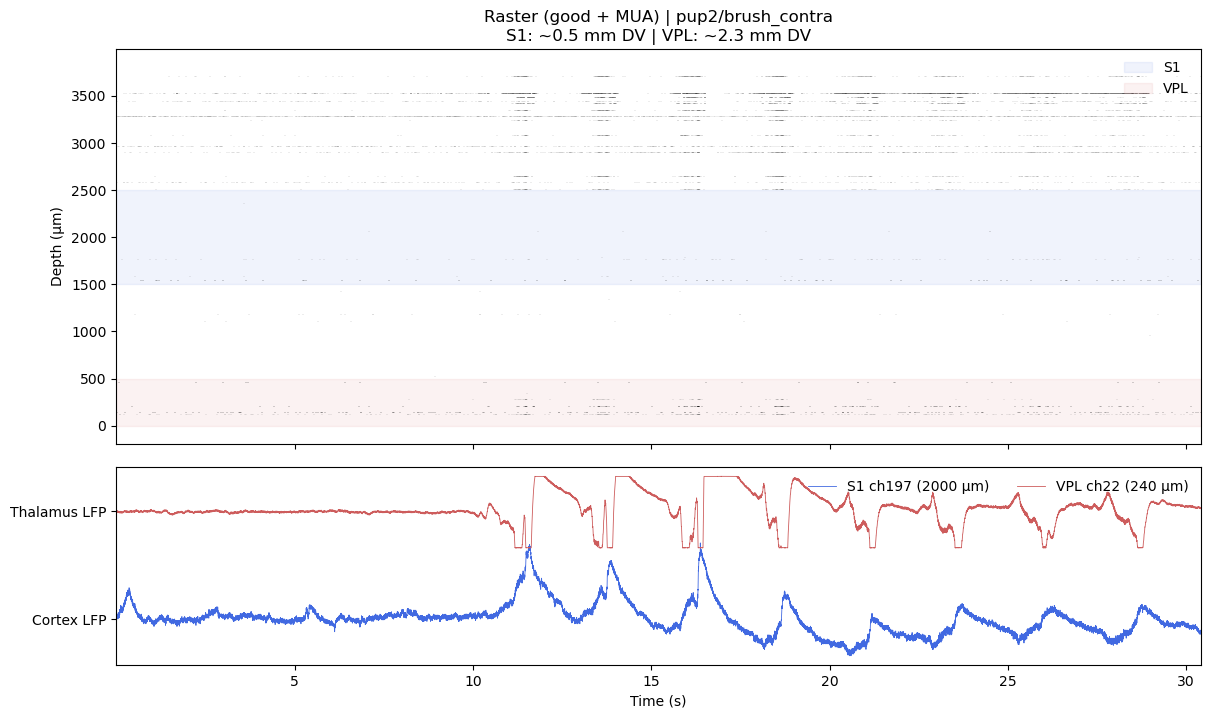

In [ ]:
# %%
# ============================================================================
# RASTER + LFP PLOT WITH CLOCK ALIGNMENT AND DV COORDINATES
# ============================================================================

# ---- Parse spike sampling rate (from params.py) ----
def parse_sample_rate(txt, default=30000.0):
    try:
        for line in txt.splitlines():
            if 'sample_rate' in line and '=' in line:
                return float(line.split('=')[-1])
        if 'ops' in txt and 'fs' in txt:
            import ast
            dct = ast.literal_eval(txt[txt.find('{'):txt.rfind('}')+1])
            if 'fs' in dct: return float(dct['fs'])
    except Exception:
        pass
    return default

spike_fs = parse_sample_rate(params_txt)

# ---- Get spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_zero = float(spike_times.min() / spike_fs)

# Convert spike times to seconds aligned to hardware clock
spike_times_s = spike_times.astype(np.float64) / spike_fs


# ---- Load channel positions and compute DV coordinates ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels, 2)
depths_um = chan_pos[:,1]  # relative depth along probe in µm

# Compute absolute DV per channel if tip_dv_mm is available
if tip_dv_mm is not None:
    min_depth_um = np.min(depths_um)
    dv_channels_mm = tip_dv_mm - (depths_um - min_depth_um) / 1000.0
    in_brain = dv_channels_mm >= 0.0
    
    max_depth_um = np.max(depths_um)
    actual_span_mm = (max_depth_um - min_depth_um) / 1000.0
    top_bank_dv_mm = tip_dv_mm - actual_span_mm
    
    print(f"\nBank span: {actual_span_mm:.2f} mm")
    print(f"Top of bank: {top_bank_dv_mm:.2f} mm DV")
    print(f"Tip (deepest site): {tip_dv_mm:.2f} mm DV")
    print(f"Channels in brain: {np.sum(in_brain)}/{len(in_brain)}")
else:
    dv_channels_mm = None
    in_brain = np.ones(len(depths_um), dtype=bool)


# ---- Load and filter cluster data ----
ci = None
for nm in ["cluster_group.tsv"]:
    p = phy_dir/nm
    if p.exists(): ci = p; break

if ci is not None:
    cluster_df = pd.read_csv(ci, sep='\t')
    if 'cluster_id' in cluster_df.columns and 'id' not in cluster_df.columns:
        cluster_df = cluster_df.rename(columns={'cluster_id':'id'})
else:
    cluster_df = pd.DataFrame({'id': np.unique(spike_clusters), 'group':'unsorted'})

if 'group' not in cluster_df.columns:
    for alt in ['KSLabel','ks_label','label']:
        if alt in cluster_df.columns:
            cluster_df['group'] = cluster_df[alt]; break
    if 'group' not in cluster_df.columns:
        cluster_df['group'] = 'unsorted'

cluster_df['group_norm'] = cluster_df['group'].astype(str).str.lower()
sel_df = cluster_df[cluster_df['group_norm'].isin(['good','accepted','pass','mua'])].copy()

# Compute median depth for each unit
unit_depth_um = {}
for cid in sel_df['id'].astype(int):
    idx = (spike_clusters == cid)
    unit_depth_um[cid] = float(np.median(spike_positions[idx, 1])) if idx.any() else np.nan

sel_df['depth_um'] = sel_df['id'].astype(int).map(unit_depth_um)
sel_df['is_good'] = sel_df['group_norm'].isin(['good','accepted','pass'])
sel_df = sel_df.sort_values('depth_um', ascending=True)

# LFP parameters
fs_lfp = 2500.0
dtype_lfp = np.int16
n_channels = 384

# Determine time window from spike data
tmin_spike = float(spike_times_s.min())
tmax_spike = float(spike_times_s.max())

# Load LFP with buffer
buffer_s = 1.0
t_start_lfp = max(0, tmin_spike - spike_zero - buffer_s)  # Align to hardware clock
t_duration_lfp = (tmax_spike - tmin_spike) + 2*buffer_s

samples_start = int(t_start_lfp * fs_lfp)
n_samples_lfp = int(t_duration_lfp * fs_lfp)

# Memory map and load
byte_offset = samples_start * n_channels * np.dtype(dtype_lfp).itemsize
mm_lfp = np.memmap(lfp_dir, dtype=dtype_lfp, mode='r', offset=byte_offset)
lfp_data = mm_lfp[:n_samples_lfp * n_channels]
lfp_ap = lfp_data.reshape(-1, n_channels).astype('float32')

# Create time vector aligned to spike clock (same zero reference)
t_lfp_aligned = np.arange(lfp_ap.shape[0]) / fs_lfp + t_start_lfp + spike_zero


# ---- Choose LFP channels by target depths ----
s1_mid_um  = (S1_upper_um + S1_lower_um) / 2.0
vpl_mid_um = (VPL_upper_um + VPL_lower_um) / 2.0

def nearest_channel_at_depth(target_um):
    return int(np.argmin(np.abs(depths_um - target_um)))

cx_ch = nearest_channel_at_depth(s1_mid_um)
th_ch = nearest_channel_at_depth(vpl_mid_um)


# ---- Select LFP window matching spike data ----
sel_lfp = (t_lfp_aligned >= tmin_spike) & (t_lfp_aligned <= tmax_spike)
t_lfp_plot = t_lfp_aligned[sel_lfp]
lfp_plot = lfp_ap[sel_lfp]

# Downsample for display
target_pts = 50000
step = max(1, int(np.ceil(lfp_plot.shape[0] / target_pts)))
idx = np.arange(0, lfp_plot.shape[0], step)
t_ds = t_lfp_plot[idx]

def z(x):
    m, s = np.median(x), np.std(x)
    return (x - m) / (s if s>0 else 1.0)

cx = z(lfp_plot[idx, cx_ch])
th = z(lfp_plot[idx, th_ch])


# ---- Plot raster + LFP ----
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 1, height_ratios=[2,1], hspace=0.08)
ax_r = fig.add_subplot(gs[0,0])
ax_l = fig.add_subplot(gs[1,0])

# Raster plot
for _, row in sel_df.iterrows():
    cid = int(row['id'])
    depth = row['depth_um']
    if np.isnan(depth): 
        continue
    ts = spike_times_s[spike_clusters == cid]
    sel = (ts >= tmin_spike) & (ts <= tmax_spike)
    if sel.any():
        color = 'k' if row['is_good'] else 'gray'
        lw = 0.25 if row['is_good'] else 0.2
        ax_r.vlines(ts[sel], depth-2, depth+2, color=color, linewidth=lw)

# Highlight regions
ax_r.axhspan(S1_upper_um, S1_lower_um, color='royalblue', alpha=0.08, label='S1')
ax_r.axhspan(VPL_upper_um, VPL_lower_um, color='indianred', alpha=0.08, label='VPL')
ax_r.legend(loc='upper right', frameon=False)
ax_r.set_xlim(tmin_spike, tmax_spike)
ax_r.set_ylabel('Depth (µm)')

# Add DV info to title if available
title_str = f'Raster (good + MUA) | {SESSION}/{STIM}'
if tip_dv_mm is not None:
    title_str += f'\nS1: ~{dv_channels_mm[cx_ch]:.1f} mm DV | VPL: ~{dv_channels_mm[th_ch]:.1f} mm DV'
ax_r.set_title(title_str)
ax_r.set_xticklabels([])  # Remove x-labels from top plot

# LFP plot
gain = 30  # Adjust vertical spacing
ax_l.plot(t_ds, cx*gain + 100, label=f'S1 ch{cx_ch} ({int(depths_um[cx_ch])} µm)', 
          color='royalblue', linewidth=0.6)
ax_l.plot(t_ds, th*gain + 300, label=f'VPL ch{th_ch} ({int(depths_um[th_ch])} µm)', 
          color='indianred', linewidth=0.6)
ax_l.set_xlim(tmin_spike, tmax_spike)
ax_l.set_yticks([100, 300])
ax_l.set_yticklabels(['Thalamus LFP','Cortex LFP'])
ax_l.set_xlabel('Time (s)')
ax_l.legend(frameon=False, ncol=2, loc='upper right')

plt.tight_layout()

# ---- Save figure ----
out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)

duration_s = int(tmax_spike - tmin_spike)
filename = f"{SESSION}_{STIM}_raster_lfp_{duration_s}s.png"
out_path = out_dir / filename

fig.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"\n✓ Saved: {out_path}")

plt.show()
